In [53]:
import pandas as pd
import numpy as np
import time

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

---
### Sub：Metrics

In [55]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [56]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.jpeg')
    plt.show()

---
### Sub：Data

In [57]:
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]
# df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['日期'] = pd.to_datetime(df['日期'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [58]:
df.head()

,日期,工業用電(百萬度),尖峰負載(MW),isHoliday,week,week_update,dayOfYear,Temp_Taipei,尖峰負載(MW)_shift7,isHoliday_shift7,weekUpdate_shift7,Temp_Taipei_shift7
0,2016-01-01,263.799,23038,1.0,5,7,1,14.6,26400.0,0.0,5.0,12.0
1,2016-01-02,261.975,23209,1.0,6,6,2,15.7,24308.0,1.0,6.0,12.1
2,2016-01-03,266.167,23686,1.0,7,7,3,16.0,23490.0,1.0,7.0,16.2
3,2016-01-04,302.227,27518,0.0,1,1,4,17.7,27207.0,0.0,1.0,13.5
4,2016-01-05,313.328,27635,0.0,2,2,5,17.8,26747.0,0.0,2.0,11.4


In [59]:
# 資料維度擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [60]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [61]:
# 根據給定的時間範圍自動產生訓練、測試資料集
def split_dataset(data, pastDay=7, futureDay=7):
    split_num_start = df[df['日期'] == trainFrom].index.item()
    split_num = df[df['日期'] == testFrom].index.item()
    split_num_end = df[df['日期'] == testTo].index.item()
    RawTrain = data[split_num_start:split_num]
    # 自我測試集
    SelfTest = data[split_num_start:split_num - futureDay]
    SelfTruth = data[split_num_start + pastDay:split_num][0]
    # 實際預測集
    RawTest = data[split_num - pastDay:split_num_end + 1 - futureDay]
    RawTrurh = data[split_num:split_num_end + 1][0]

    print("RawTrain", RawTrain.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [62]:
# 僅負責滾動資料
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [102]:
# 僅負責滾動資料
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, len(test)-pastDay+futureDay):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    print('buildTest.shape', X_test.shape)
    return X_test

In [100]:
# 拆分訓練與驗證，需要手動切割時才使用
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [131]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    # Append Data
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    # Reshape
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    print('Truth.shape, Forecast.shape', shape, forecast.shape)
    return forecast

---
### Sub：Model

In [90]:
# 關閉警告
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [91]:
def buildModel(shape, dropout_rate=0.1):
    # Initialising the LSTM
    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    model.add(SimpleRNN(units = 256, return_sequences = True, input_shape = (shape[1], shape[2])))
    model.add(Dropout(dropout_rate))
#     model.add(CuDNNLSTM(units = 128, return_sequences = True))
#     model.add(Dropout(dropout_rate))
    model.add(Flatten())
    # Adding the output layer
    model.add(Dense(units = 1))
    
    model.summary()
    return model

---
### Main

In [92]:
features = [
            '工業用電(百萬度)', 
            '尖峰負載(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]

In [93]:
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'

In [94]:
# 計時開始
tStart = time.time()

In [95]:
# 特徵選取
RawData = augFeatures(df, features)
# 正規化
sc, RawData = normalize(RawData)

In [103]:
# 自定義變數
Timesteps = 7
OutputDay = 7

# 資料選取
RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

# 驗證資料
# X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)

RawTrain (728, 6)
RawTest, RawTrurh (272, 6) (266,)
SelfTest, SelfTruth (727, 6) (721,)
X_train.shape, Y_train.shape (720, 7, 6) (720, 1)
buildTest.shape (721, 7, 6)
buildTest.shape (266, 7, 6)


In [72]:
model = buildModel(X_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 7, 256)            67328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1793      
Total params: 69,121
Trainable params: 69,121
Non-trainable params: 0
_________________________________________________________________


In [73]:
# initialize optimizer
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
# model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])

In [74]:
# callback reduce_lr
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='auto', verbose=1)
# callback cb_EarlyStop
cb_EarlyStop = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")

In [75]:
batch_size = 16
epochs = 200

history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1, 
                    shuffle=False,
                    callbacks=[cb_reduce_lr, cb_EarlyStop],
                    validation_split=0.1)

Train on 648 samples, validate on 72 samples
Epoch 1/200
648/648 [==============================] - 6s 10ms/step - loss: 0.0464 - val_loss: 0.0112
Epoch 2/200
648/648 [==============================] - 0s 603us/step - loss: 0.0232 - val_loss: 0.0070
Epoch 3/200
648/648 [==============================] - 0s 603us/step - loss: 0.0131 - val_loss: 0.0087
Epoch 4/200
648/648 [==============================] - 0s 618us/step - loss: 0.0216 - val_loss: 0.0067
Epoch 5/200
648/648 [==============================] - 0s 580us/step - loss: 0.0137 - val_loss: 0.0130
Epoch 6/200
648/648 [==============================] - 0s 602us/step - loss: 0.0206 - val_loss: 0.0222
Epoch 7/200
648/648 [==============================] - 0s 628us/step - loss: 0.0223 - val_loss: 0.0145
Epoch 8/200
648/648 [==============================] - 0s 700us/step - loss: 0.0229 - val_loss: 0.0050
Epoch 9/200
648/648 [==============================] - 0s 628us/step - loss: 0.0212 - val_loss: 0.0014
Epoch 10/200
648/648 [=======

648/648 [==============================] - 0s 558us/step - loss: 0.0032 - val_loss: 5.1295e-04
Epoch 77/200
648/648 [==============================] - 0s 571us/step - loss: 0.0027 - val_loss: 4.5143e-04
Epoch 78/200
648/648 [==============================] - 0s 569us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 79/200
648/648 [==============================] - 0s 558us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 80/200
648/648 [==============================] - 0s 573us/step - loss: 0.0033 - val_loss: 5.6938e-04
Epoch 81/200
648/648 [==============================] - 0s 544us/step - loss: 0.0019 - val_loss: 7.6057e-04
Epoch 82/200
648/648 [==============================] - 0s 589us/step - loss: 0.0017 - val_loss: 6.2583e-04
Epoch 83/200
648/648 [==============================] - 0s 564us/step - loss: 0.0016 - val_loss: 5.6331e-04
Epoch 84/200
648/648 [==============================] - 0s 575us/step - loss: 0.0017 - val_loss: 6.9631e-04
Epoch 85/200
648/648 [===========================

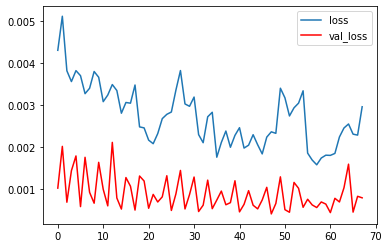

In [76]:
plt.plot(history.history['loss'][25:], label = 'loss')
plt.plot(history.history['val_loss'][25:], color = 'red', label = 'val_loss')
plt.legend()
plt.show()

In [77]:
#計時結束
tEnd = time.time()
print('Total time spent.....',tEnd - tStart, 'second')

Total time spent..... 42.907739877700806 second


---
## Time

In [78]:
t = 8
save = False
# save = False
model_name = '(XT_RNN_2017)'

---
## Load Model

In [79]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_cLSTM(7to7)_model_0' + str(t) + '.h5')

---
## Self-Prediction

In [133]:
# 真實值
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)

self_predict = forecast(model, S_test, self_trurh.shape)
self_predict = deNormalize(sc, self_predict)

Truth.shape, Forecast.shape (721, 1) (721, 1)


RMSE 9.274723549446861
MAPE 2.144909406382568


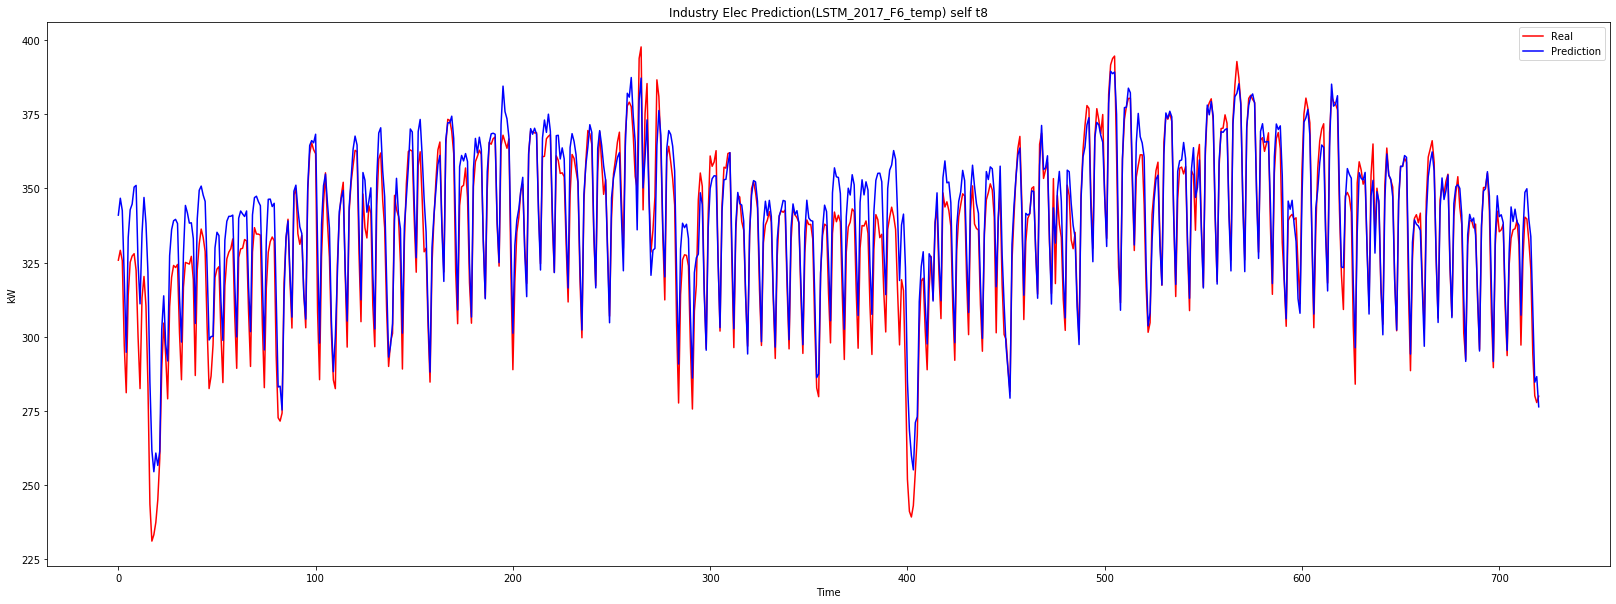

In [134]:
calcError(self_trurh, self_predict)
showPlot(self_trurh, self_predict, model_name , "self", size="L", save=save)

---
## Test-Prediction

In [135]:
# 真實值
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)

# 預測值
test_predict = forecast(model, X_test, test_trurh.shape)
test_predict = deNormalize(sc, test_predict)

Truth.shape, Forecast.shape (266, 1) (266, 1)


RMSE 10.689531151720717
MAPE 2.5291448060011197


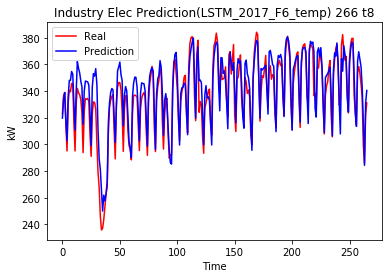

In [136]:
calcError(test_trurh, test_predict)
showPlot(test_trurh, test_predict, model_name , str(266), save=save)

---
## Save Model

In [ ]:
# import h5py
# Model.save('Model/industryElec_cLSTM(7to7)_model_01.h5')